In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

***GETTING DATA***

In [3]:
recipe_df = pd.read_csv("data/Foodcom/recipes.csv", usecols=["RecipeId", "Name"], dtype={"RecipeId": "int32", "Name": "str"})
rating_df = pd.read_csv("data/Foodcom/reviews.csv", usecols=["AuthorId", "RecipeId", "Rating"], dtype={"RecipeId": "int32", "Rating": "float32"})


***EDA***

In [4]:
rating_df.head()

,RecipeId,AuthorId,Rating
0,992,2008,5.0
1,4384,1634,4.0
2,4523,2046,2.0
3,7435,1773,5.0
4,44,2085,5.0


In [5]:
print(rating_df.shape)
print(list(rating_df.columns))

(1401982, 3)
['RecipeId', 'AuthorId', 'Rating']


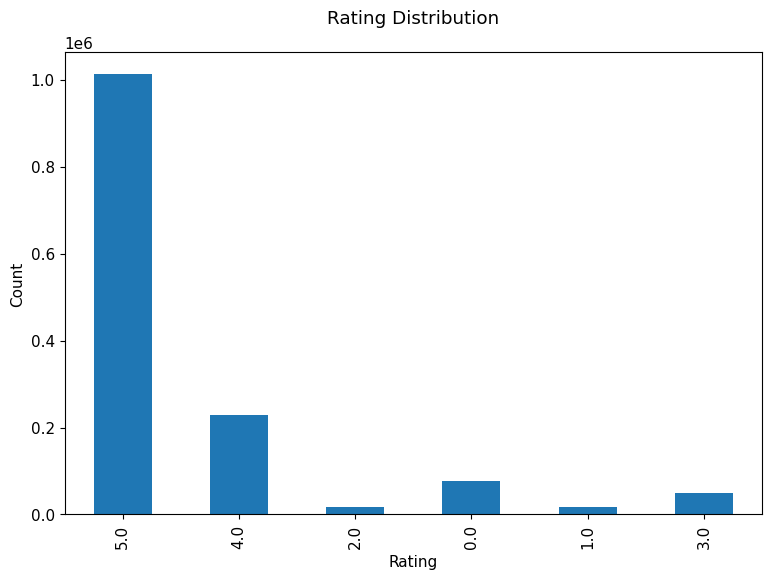

In [6]:
plt.figure(figsize=(9, 6))
plt.rc("font", size=11)
rating_df.Rating.value_counts(sort=False).plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.savefig('system1.png', bbox_inches='tight')
plt.show()

In [7]:
print(recipe_df.shape)
print(list(recipe_df.columns))

(522517, 2)
['RecipeId', 'Name']


***PREPROCESS***

In [8]:
### To ensure statistical significance

# Exclude Author/Reviewer with less than 20 ratings
countAuthor = rating_df["AuthorId"].value_counts()
rating_df = rating_df[rating_df["AuthorId"].isin(countAuthor[countAuthor >= 20].index)]

# Exclude Recipe with less than 100 ratings
countRecipe = rating_df["RecipeId"].value_counts()
rating_df = rating_df[rating_df["RecipeId"].isin(countRecipe[countRecipe >= 100].index)]

rating_df.shape

(72320, 3)

***Modeling***
## Collaborative Filtering Using k-Nearest Neighbors (kNN)
kNN is an algorithm in machine learning designed to identify groups of users with similar preferences by examining shared recipe ratings. It then generates predictions by averaging the ratings of the top-k closest neighbors. To illustrate, we initially organize the ratings into a matrix format, where each item (recipe) corresponds to a row and each user corresponds to a column.

In [9]:
df = pd.merge(rating_df, recipe_df, on="RecipeId")
df

,RecipeId,AuthorId,Rating,Name
0,2886,2312,5.0,Best Banana Bread
1,2886,9869,5.0,Best Banana Bread
2,2886,25455,4.0,Best Banana Bread
3,2886,25792,5.0,Best Banana Bread
4,2886,28397,5.0,Best Banana Bread
...,...,...,...,...
72315,420398,217634,0.0,Ice Cubes
72316,420398,2156777,5.0,Ice Cubes
72317,420398,527754,5.0,Ice Cubes
72318,420398,1581225,5.0,Ice Cubes


In [10]:
combinedRecipeRating = df.dropna(axis=0, subset=["Name"])
recipeRatingCount = (combinedRecipeRating.
                     groupby(by=["Name"])["Rating"].
                     count().
                     reset_index().
                     rename(columns={"Rating": "totalRatingCount"})
                     [["Name", "totalRatingCount"]]
)
recipeRatingCount.head()

,Name,totalRatingCount
0,&quot;Whatever Floats Your Boat&quot; Brownies!,613
1,1 Pan Fudge Cake,104
2,24k Carrots,152
3,4 Minute Spicy Garlic Shrimp,195
4,Absolute Best Ever Lasagna,219


In [11]:
df = pd.DataFrame(combinedRecipeRating)
df = df.drop(columns=['AuthorId'])
final_ratings = df.groupby(['RecipeId', 'Name']).agg(
    Rating=('Rating', 'mean'),
    NumberRating=('Rating', 'count')
).reset_index()
final_ratings

,RecipeId,Name,Rating,NumberRating
0,76,Alfredo Sauce,4.587719,114
1,1209,Spinach Artichoke Dip,4.662791,258
2,2496,Dark Chocolate Cake,4.720833,240
3,2642,Taco Seasoning Mix,4.739130,207
4,2886,Best Banana Bread,4.652406,187
...,...,...,...,...
402,221743,Kittencal's Best Blasted Rapid-Roast Whole Chi...,4.802198,182
403,222188,Vanilla Buttercream Frosting (From Sprinkles ...,4.639706,136
404,251220,Kittencal's Fluffiest Scrambled Eggs,4.850000,120
405,261889,Kittencal's Buttery Cut-Out Sugar Cookies W/ I...,4.544910,167


In [12]:
ratingWithTotalRatingCount = combinedRecipeRating.merge(recipeRatingCount, left_on="Name", right_on="Name", how="left")
ratingWithTotalRatingCount.head()

,RecipeId,AuthorId,Rating,Name,totalRatingCount
0,2886,2312,5.0,Best Banana Bread,187
1,2886,9869,5.0,Best Banana Bread,187
2,2886,25455,4.0,Best Banana Bread,187
3,2886,25792,5.0,Best Banana Bread,187
4,2886,28397,5.0,Best Banana Bread,187


In [13]:
recipeFeatures = ratingWithTotalRatingCount.pivot_table(index="Name", columns="AuthorId", values="Rating").fillna(0)
recipeFeatures

AuthorId,1533,1535,1676,1792,1891,1962,2310,2312,2586,2695,...,2001604211,2001625595,2002093000,2002169932,2002256447,2002273175,2002312797,2002321540,2002404048,2002754832
Name,,,,,,,,,,,,,,,,,,,,,
&quot;Whatever Floats Your Boat&quot; Brownies!,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1 Pan Fudge Cake,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24k Carrots,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Minute Spicy Garlic Shrimp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0
Absolute Best Ever Lasagna,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Yes, Virginia There is a Great Meatloaf",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Yummy Baked Potato Skins,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
Yummy Crunchy Apple Pie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
from scipy.sparse import csr_matrix
recipeFeaturesMatrix = csr_matrix(recipeFeatures.values)

from sklearn.neighbors import NearestNeighbors
model = NearestNeighbors(metric="cosine", algorithm="brute")
model.fit(recipeFeaturesMatrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [15]:
df = pd.read_csv("data/Foodcom/recipes.csv")
final_df = pd.merge(final_ratings, df.drop(columns=['Name']), on='RecipeId', how='left')

final_df

,RecipeId,Name,Rating,NumberRating,Unnamed: 0,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,...,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions
0,76,Alfredo Sauce,4.587719,114,37,1535,Marg CaymanDesigns,PT10M,PT5M,PT15M,...,31.5,159.0,312.4,2.5,0.0,0.2,8.7,4.0,NaN,"c(""Place butter in microwave safe pot and heat..."
1,1209,Spinach Artichoke Dip,4.662791,258,772,1755,Juli9251,NaN,PT30M,PT30M,...,6.5,34.1,291.6,5.5,2.8,1.4,7.7,15.0,4 1/2 cups,"c(""Preheat oven to 375°F."", ""Mix together Parm..."
2,2496,Dark Chocolate Cake,4.720833,240,1090,1535,Marg CaymanDesigns,PT50M,PT10M,PT1H,...,1.4,20.3,252.4,30.9,1.4,20.1,2.8,NaN,NaN,"c(""Heat oven to 350°F."", ""Grease and flour two..."
3,2642,Taco Seasoning Mix,4.739130,207,1205,1539,opal Fitzgerald,NaN,PT5M,PT5M,...,0.1,0.0,2372.5,6.0,1.5,1.5,0.9,NaN,1 package,"c(""Combine all ingredients in a small bowl and..."
4,2886,Best Banana Bread,4.652406,187,1436,1762,lkadlec,PT1H,PT10M,PT1H10M,...,6.2,61.6,338.3,42.5,1.4,24.4,3.7,10.0,1 loaf,"c(""Remove odd pots and pans from oven."", ""Preh..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,221743,Kittencal's Best Blasted Rapid-Roast Whole Chi...,4.802198,182,212592,89831,Kittencalrecipezazz,PT1H,PT20M,PT1H20M,...,17.2,243.8,294.5,2.6,0.6,0.5,57.6,NaN,NaN,"c(""Rinse the chicken inside and out well under..."
403,222188,Vanilla Buttercream Frosting (From Sprinkles ...,4.639706,136,213030,454328,C. Taylor,NaN,PT10M,PT10M,...,9.7,40.7,27.2,35.0,0.0,34.3,0.2,NaN,12 cupcakes,"c(""In a bowl add sugar then add butter. Beat t..."
404,251220,Kittencal's Fluffiest Scrambled Eggs,4.850000,120,241342,89831,Kittencalrecipezazz,NaN,PT5M,PT5M,...,5.9,384.2,496.3,1.5,0.0,0.4,13.1,2.0,NaN,"c(""In a bowl whisk the eggs vigorously with mi..."
405,261889,Kittencal's Buttery Cut-Out Sugar Cookies W/ I...,4.544910,167,251699,89831,Kittencalrecipezazz,PT4M,PT2H,PT2H4M,...,3.5,24.6,107.8,22.0,0.3,12.6,1.6,NaN,NaN,"c(""For cookies; in a large bowl combine butter..."


In [16]:
# def recommend_recipe(name):
#     id = np.where(recipeFeatures.index==name)[0][0]
#     distances, indices = model.kneighbors(recipeFeatures.iloc[id, :].values.reshape(1, -1), n_neighbors=6)
#     data = []
#     print(indices)
#     for i in indices:
#         for j in i:
#             item = []
#             temp_df = (final_df[final_df["Name"]==recipeFeatures.index[i[0]]])
#             print(temp_df["Name"])
#             item.append(temp_df.drop_duplicates("Name")["Name"].values)
#             item.append(temp_df.drop_duplicates("Name")["AuthorName"].vef recommend_recipe(name):
#     id = np.where(recipeFeatures.index==name)[0][0]
#     distances, indices = model.kneighbors(recipeFeatures.iloc[id, :].values.reshape(1, -1), n_neighbors=6)
#     data = []
#     print(indices)
#     for i in indices[0]:
#         item = []
#         temp_df = (final_df[final_df["Name"]==recipeFeatures.index[i]])
#         print(temp_df["Name"])
#         item.append(temp_df.drop_duplicates("Name")["Name"].values)
#         item.append(temp_df.drop_duplicates("Name")["AuthorName"].values)
#         item.append(temp_df.drop_duplicates("Name")["Images"].values)
#         data.append(item)alues)
#         item.append(temp_df.drop_duplicates("Name")["Images"].values)
#         data.append(item)

        
#     return data
#         # print(temp_df.drop_duplicates("Name")["Images"])
#     # for i in range(len(indices)):
#         # recipes = recipeFeatures.index[indices[i]]
#         # for j in recipes:
#         #     print(j)
#     # for i in range(0, len(distances.flatten())):
#     #     if i==0:
#     #         print(f"Recommendation for {format(recipeFeatures.index[id])}:\n")
#     #     else:
#     #         print(f"{i}: {recipeFeatures.index[indices.flatten()[i]]}, with distance of {distances.flatten()[i]}:")
    
# name = "Spinach Artichoke Dip"
# data = recommend_recipe(name)


In [17]:
def recommend_recipe(name):
    id = np.where(recipeFeatures.index == name)[0][0]
    distances, indices = model.kneighbors(recipeFeatures.iloc[id, :].values.reshape(1, -1), n_neighbors=6)
    data = []
    for i in indices[0]:  # indices is a 2D array, so we need to access the first element
        item = []
        temp_df = final_df[final_df["Name"] == recipeFeatures.index[i]]
        item.append(temp_df.drop_duplicates("Name")["Name"].values[0])
        item.append(temp_df.drop_duplicates("Name")["AuthorName"].values[0])
        item.append(temp_df.drop_duplicates("Name")["Images"].values[0])
        data.append(item)
    return data

# Example usage
data = recommend_recipe("Spinach Artichoke Dip")
for recommendation in data:
    print(f"Name: {recommendation[0]}, Author: {recommendation[1]}, Image: {recommendation[2]}")


Name: Spinach Artichoke Dip, Author: Juli9251, Image: https://img.sndimg.com/food/image/upload/w_555,h_416,c_fit,fl_progressive,q_95/v1/img/recipes/12/09/Q1us4KDT27bPD0yngmgv_0S9A2706.jpg
Name: Creamy Cajun Chicken Pasta, Author: Lorac, Image: https://img.sndimg.com/food/image/upload/w_555,h_416,c_fit,fl_progressive,q_95/v1/img/recipes/39/08/7/VPeSMiYHRce4BWsyj7Nl_0S9A5582.jpg
Name: Bourbon Chicken, Author: LinMarie, Image: https://img.sndimg.com/food/image/upload/w_555,h_416,c_fit,fl_progressive,q_95/v1/img/recipes/45/80/9/MwuCd6HpQ5mDvn4OLRkA_0S9A9886.jpg
Name: Crock-Pot Chicken With Black Beans &amp; Cream Cheese, Author: Jen Santiago, Image: https://img.sndimg.com/food/image/upload/w_555,h_416,c_fit,fl_progressive,q_95/v1/img/recipes/89/20/4/uxMwt1VGQ5m2ePyzwHWy_salsa-chicken-black-beans-2312.jpg
Name: Mexican Rice, Author: Pot Scrubber, Image: https://img.sndimg.com/food/image/upload/w_555,h_416,c_fit,fl_progressive,q_95/v1/img/recipes/11/78/92/WlojZNwSSKqBLqEXjpWA_THE%20FOOD%20GA

In [18]:
data

[['Spinach Artichoke Dip',
  'Juli9251',
  'https://img.sndimg.com/food/image/upload/w_555,h_416,c_fit,fl_progressive,q_95/v1/img/recipes/12/09/Q1us4KDT27bPD0yngmgv_0S9A2706.jpg'],
 ['Creamy Cajun Chicken Pasta',
  'Lorac',
  'https://img.sndimg.com/food/image/upload/w_555,h_416,c_fit,fl_progressive,q_95/v1/img/recipes/39/08/7/VPeSMiYHRce4BWsyj7Nl_0S9A5582.jpg'],
 ['Bourbon Chicken',
  'LinMarie',
  'https://img.sndimg.com/food/image/upload/w_555,h_416,c_fit,fl_progressive,q_95/v1/img/recipes/45/80/9/MwuCd6HpQ5mDvn4OLRkA_0S9A9886.jpg'],
 ['Crock-Pot Chicken With Black Beans &amp; Cream Cheese',
  'Jen Santiago',
  'https://img.sndimg.com/food/image/upload/w_555,h_416,c_fit,fl_progressive,q_95/v1/img/recipes/89/20/4/uxMwt1VGQ5m2ePyzwHWy_salsa-chicken-black-beans-2312.jpg'],
 ['Mexican Rice',
  'Pot Scrubber',
  'https://img.sndimg.com/food/image/upload/w_555,h_416,c_fit,fl_progressive,q_95/v1/img/recipes/11/78/92/WlojZNwSSKqBLqEXjpWA_THE%20FOOD%20GAYS%20-%20MEXICAN%20RICE-2.jpg'],
 ['Ch

In [19]:
# import pickle
# pickle.dump(recipeFeatures, open("artifacts/pivot_CF.pickle", "wb"))
# pickle.dump(final_df, open("artifacts/recipe_list_CF.pickle", "wb"))
# pickle.dump(model, open("artifacts/model_CF.pickle", "wb"))

In [20]:
final_df.columns

Index(['RecipeId', 'Name', 'Rating', 'NumberRating', 'Unnamed: 0', 'AuthorId',
       'AuthorName', 'CookTime', 'PrepTime', 'TotalTime', 'DatePublished',
       'Description', 'Images', 'RecipeCategory', 'Keywords',
       'RecipeIngredientQuantities', 'RecipeIngredientParts',
       'AggregatedRating', 'ReviewCount', 'Calories', 'FatContent',
       'SaturatedFatContent', 'CholesterolContent', 'SodiumContent',
       'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent',
       'RecipeServings', 'RecipeYield', 'RecipeInstructions'],
      dtype='object')